In [1]:
import jax.numpy as np
from jax.numpy import pi as pi
from jax.experimental.ode import odeint

In [2]:
# Kinetic and general parameters

R = 8.314e6                 # [Pa.cm³/(K.mol.)]
k1 = 0.04                   # [s-¹]
k1_Inv = 6.40e6             # [cm³/s-mol]
k2 = 4.20                   # [s-¹]
k2_Inv = 56.38              # [cm³/s-mol]

    
# Molecular weights
MM_B = 78.00                # [g/mol] 

# Fixed Reactor Values
T = 1173.15                 # [K]  =900[°C] (Isothermal)
Q = 3600 * 0.01e-4          # [mol/(h.cm².atm1/4)]
selec = 1500

# Tube side
Pt = 101325.0               # Pressure [Pa](1atm)
v0 = 3600 * (2 / 15)        # Vol. Flow rate [cm³ h-¹]
Ft0 = Pt * v0 / (R * T)     # Initial molar flow rate[mol/h] - Pure CH4

# Shell side
Ps = 101325.0               # Pressure [Pa](1atm)
ds = 3                      # Diameter[cm]
v_He = 3600 * (1 / 6)       # Vol. flow rate[cm³/h]


In [3]:
def dma_mr_model(F, z, dt,v_He,v0, F_He, Ft0):

    At = 0.25 * np.pi * (dt ** 2)  # Cross sectional area [cm2].
    
    # Avoid negative flows that can happen in the first integration steps.
    # Consequently this avoids that any molar balance (^ 1/4 terms) generates
    # complex numbers.
    F = np.where(F <= 1e-9, 1e-9, F)
    
    

    
    # Evaluate the total flow rate in the tube & shell.
    Ft = F[0:4].sum()
    Fs = F[4:].sum() + F_He
    v = v0 * (Ft / Ft0)

    # Concentrations from molar flow rates [mol/cm3].
    C = F[:4] / v
    # Partial pressures - Tube & Shell [mol/cm3].

    P0t = (Pt / 101325) * (F[0] / Ft)
    P1t = (Pt / 101325) * (F[1] / Ft)
    P2t = (Pt / 101325) * (F[2] / Ft)
    P3t = (Pt / 101325) * (F[3] / Ft)

    P0s = (Ps / 101325) * (F[4] / Fs)
    P1s = (Ps / 101325) * (F[5] / Fs)
    P2s = (Ps / 101325) * (F[6] / Fs)
    P3s = (Ps / 101325) * (F[7] / Fs)
    
    

    # First reaction rate.
    r0 = 3600 * k1 * C[0] * (1 - ((k1_Inv * C[1] * C[2] ** 2) / 
                                  (k1 * (C[0])**2 )))
    

    # This replicates an if statement to avoid division by zero, 
    # whenever the concentrations are near zero. JAX's syntax compatible.
    C0_aux = C[0]
    r0 = np.where(C0_aux <= 1e-9, 0, r0)
    

    # Second reaction rate.
    r1 = 3600 * k2 * C[1] * (1 - ((k2_Inv * C[3] * C[2] ** 3) / 
                                  (k2 * (C[1])**3 )))
    

    # Same as before
    C1_aux = C[1]
    r1 = np.where(C1_aux <= 1e-9 , 0, r1)  

    # Molar balances adjustment with experimental data.
    eff = 0.9
    vb = 0.5
    Cat = (1 - vb) * eff

    # Molar balances dFdz - Tube (0 to 3) & Shell (4 to 7)
    dF0 = -Cat * r0 * At - (Q / selec) * ((P0t ** 0.25) - (P0s ** 0.25)) * pi * dt

    dF1 = 1 / 2 * Cat * r0 * At - Cat * r1 * At 
    - (Q / selec) * ((P1t ** 0.25) - (P1s ** 0.25)) * pi * dt

    dF2 = Cat * r0 * At + Cat * r1 * At- (Q) * ((P2t ** 0.25) - (P2s ** 0.25)) * pi * dt

    dF3 = (1 / 3) * Cat * r1 * At - (Q / selec) * ((P3t ** 0.25) - (P3s ** 0.25)) * pi * dt

    dF4 = (Q / selec) * ((P0t ** 0.25) - (P0s ** 0.25)) * pi * dt

    dF5 = (Q / selec) * ((P1t ** 0.25) - (P1s ** 0.25)) * pi * dt

    dF6 = (Q) * ((P2t ** 0.25) - (P2s ** 0.25)) * pi * dt
    
    dF7 = (Q / selec) * ((P3t ** 0.25) - (P3s ** 0.25)) * pi * dt
    
    dFdz = np.array([ dF0, dF1, dF2, dF3, dF4, dF5, dF6, dF7 ])

    return dFdz

In [4]:
def dma_mr_design(u):


    L =  u[0]                   # Tube length   [cm2]
    dt = u[1]                   # Tube diameter [cm2]

    F_He = Ps * v_He / (R * T)  # Sweep gas molar flow rate [mol/h].

    # Initial conditions.
    y0 = np.hstack((Ft0, np.zeros(7)))
    rtol, atol = 1e-10, 1e-10

    # Integration of mol balances using Jax's Dormand Prince.
    z = np.linspace(0, L, 2000)
    F = odeint(dma_mr_model, y0, z, dt,v_He,v0, F_He, Ft0, rtol=rtol, atol=atol)
    
    # Calculating outputs (AOS/DOS) from states.
    F_C6H6 = ((F[-1, 3] * 1000) * MM_B)
    X_CH4  = (100 * (Ft0 - F[-1, 0] - F[-1, 4]) / Ft0)

    return np.array([F_C6H6, X_CH4])

In [5]:
from pypo import nlp_based_approach

In [6]:
DOS_bounds = np.array([[15,25],
                       [35,45]])

# Discretization Grid - 10x10 grid for DOS.
DOS_resolution =  [10, 10]

# Lower and upper bounds of AIS design variables.
lb = np.array([10,  0.1])
ub = np.array([300, 2])

# Initial estimate for NLP.
u0 = np.array([50, 1])

In [7]:
def plug_flow(u):
    return u[0] - 30.0*u[1]

con= {'type': 'ineq', 'fun': plug_flow}

 You have selected automatic differentiation as a method for obtaining higher-order data (Jacobians/Hessian). Make sure your process model is JAX-compatible implementation-wise.


  0%|          | 0/100 [00:00<?, ?it/s]

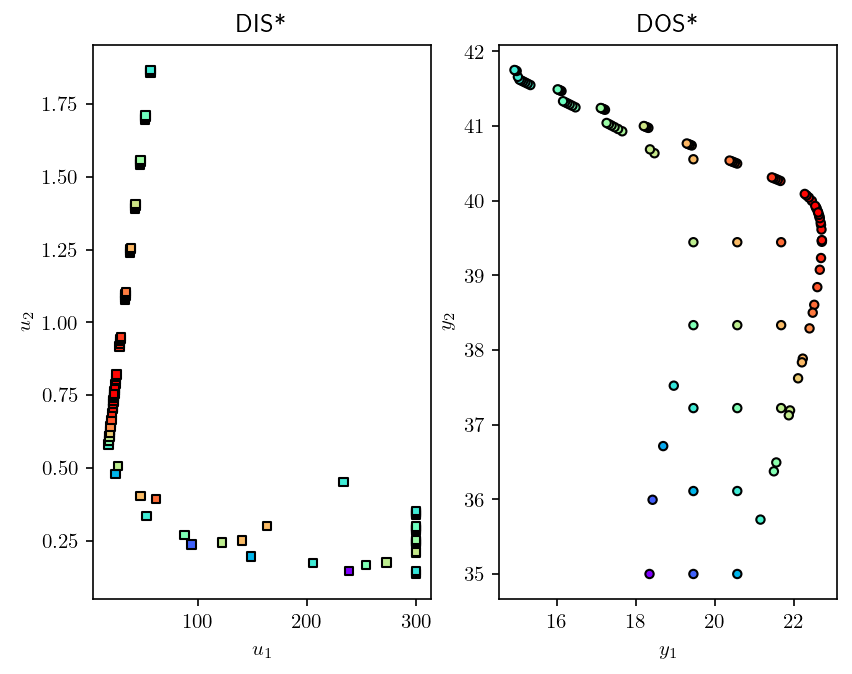

In [8]:
fDIS, fDOS, convergence = nlp_based_approach(DOS_bounds, 
                                             DOS_resolution,
                                             dma_mr_design, 
                                             u0,
                                             lb,
                                             ub,
                                             constr=(con),
                                             method='ipopt',
                                             plot=True,
                                             ad=True,
                                             warmstart=True)

In [9]:
from pypo import multimodel_rep, OI_eval

In [10]:
def dma_mr_mvs(u):

    v0  = u[0]                  # Vol. flow rate [cm³ h-¹]
    v_He = u[1]                 # Vol. flow rate[cm³/h]

    # Fixed design variables:
    L =  17.00                  # Tube length   [cm]
    dt = 0.55                   # Tube diameter [cm]

    Ft0 = Pt*v0/(R*T)           # Initial molar flow rate [mol/h] - Pure CH4
    
    F_He = Ps * v_He / (R * T)  # Sweep gas molar flow rate [mol/h]
    

    # Initial conditions and integrator tolerance.
    y0 = np.hstack((Ft0, np.zeros(7)))
    rtol, atol = 1e-10, 1e-10

    # Integration of mol balances using Jax's Dormand Prince.
    z = np.linspace(0, L, 2000)
    F = odeint(dma_mr_model, y0, z, dt, v_He,v0, F_He, Ft0, rtol=rtol, atol=atol)
    
    # Calculating outputs (AOS/DOS) from states.
    F_C6H6 = ((F[-1, 3] * 1000) * MM_B)
    X_CH4  = (100 * (Ft0 - F[-1, 0] - F[-1, 4]) / Ft0)

    return np.array([F_C6H6, X_CH4])

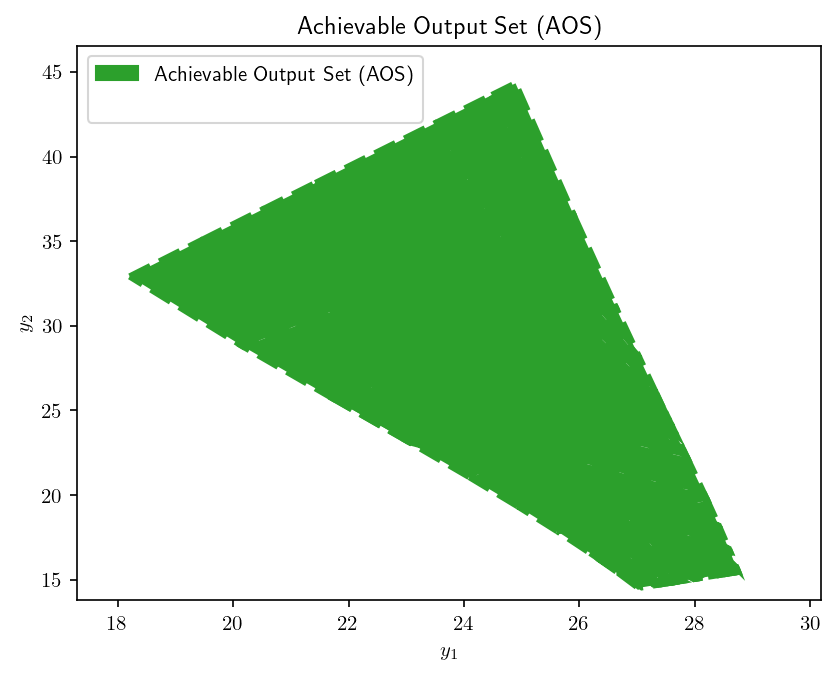

In [11]:
AIS_bounds =  np.array([[450, 1500],
                        [450, 1500]])

AIS_resolution =  [10, 10]

AOS_region  =  multimodel_rep(AIS_bounds, AIS_resolution, dma_mr_mvs)


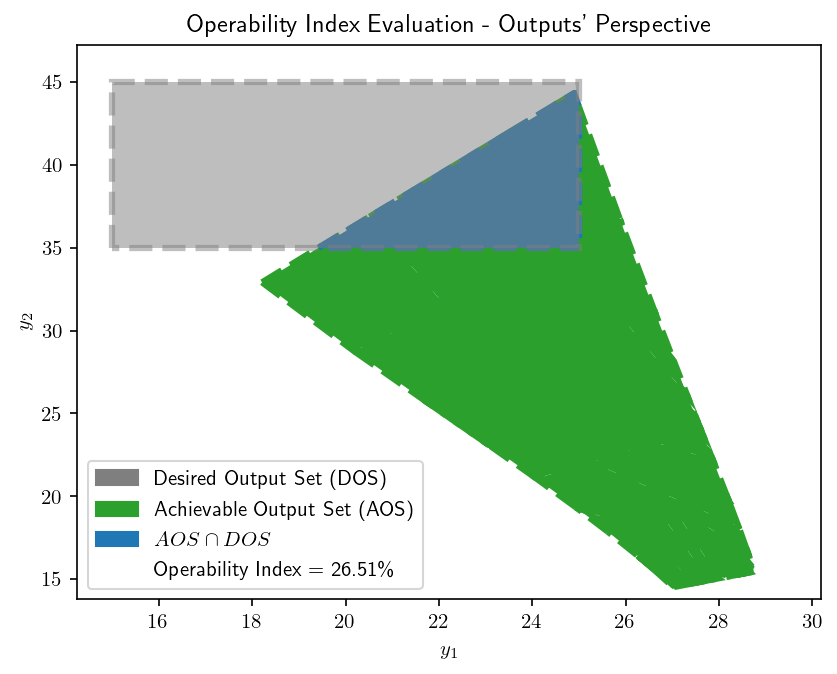

In [12]:
OI = OI_eval(AOS_region, DOS_bounds)